## Группа DS03-onl

Студент Парфимович Алексей

## Домашнее задание №24

Для произвольно выбранного датасета провести обработку данных и построить предсказательную модель с использованием функционала pySpark.

In [101]:
# Создать переменные окружения для работы с pyspark
import os
os.environ['PYSPARK_PYTHON'] = 'python'
os.environ['PYSPARK_DRIVER_PYTHON'] = 'jupyter'

import pyspark

from pyspark import SparkConf
from pyspark import SparkContext
from pyspark.sql import SparkSession

import pyspark.sql.functions as F


import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline
from matplotlib import pyplot as plt

Загрузить данные

In [83]:
spark = SparkSession.builder \
  .master("local[*]") \
  .appName("Pyspark") \
  .getOrCreate()

In [84]:
df = spark.read.option('delimiter',';').csv("winequality-white.csv", inferSchema="true", header="true")
df.printSchema()

root
 |-- fixed acidity: double (nullable = true)
 |-- volatile acidity: double (nullable = true)
 |-- citric acid: double (nullable = true)
 |-- residual sugar: double (nullable = true)
 |-- chlorides: double (nullable = true)
 |-- free sulfur dioxide: double (nullable = true)
 |-- total sulfur dioxide: double (nullable = true)
 |-- density: double (nullable = true)
 |-- pH: double (nullable = true)
 |-- sulphates: double (nullable = true)
 |-- alcohol: double (nullable = true)
 |-- quality: integer (nullable = true)



In [85]:
# Схема набора данных
df.count(), len(df.columns)

(4898, 12)

Убрать пробелы из наименований столбцов

In [86]:
df = df \
    .withColumnRenamed('fixed acidity', 'fixed_acidity') \
    .withColumnRenamed('volatile acidity','volatile_acidity') \
    .withColumnRenamed('citric acid','citric_acid') \
    .withColumnRenamed('residual sugar','residual_sugar') \
    .withColumnRenamed('free sulfur dioxide','free_sulfur_dioxide') \
    .withColumnRenamed('total sulfur dioxide','total_sulfur_dioxide')

df.show(5)

+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+
|fixed_acidity|volatile_acidity|citric_acid|residual_sugar|chlorides|free_sulfur_dioxide|total_sulfur_dioxide|density|  pH|sulphates|alcohol|quality|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+
|          7.0|            0.27|       0.36|          20.7|    0.045|               45.0|               170.0|  1.001| 3.0|     0.45|    8.8|      6|
|          6.3|             0.3|       0.34|           1.6|    0.049|               14.0|               132.0|  0.994| 3.3|     0.49|    9.5|      6|
|          8.1|            0.28|        0.4|           6.9|     0.05|               30.0|                97.0| 0.9951|3.26|     0.44|   10.1|      6|
|          7.2|            0.23|       0.32|           8.5|    0.058|               47.0|           

Выполнить удаление дубликатов

In [87]:
# Получить только уникальные записи
df = df.distinct()

df.count()

3961

Построить корреляционную матрицу признаков  
Проанализировать зависимости

<AxesSubplot: >

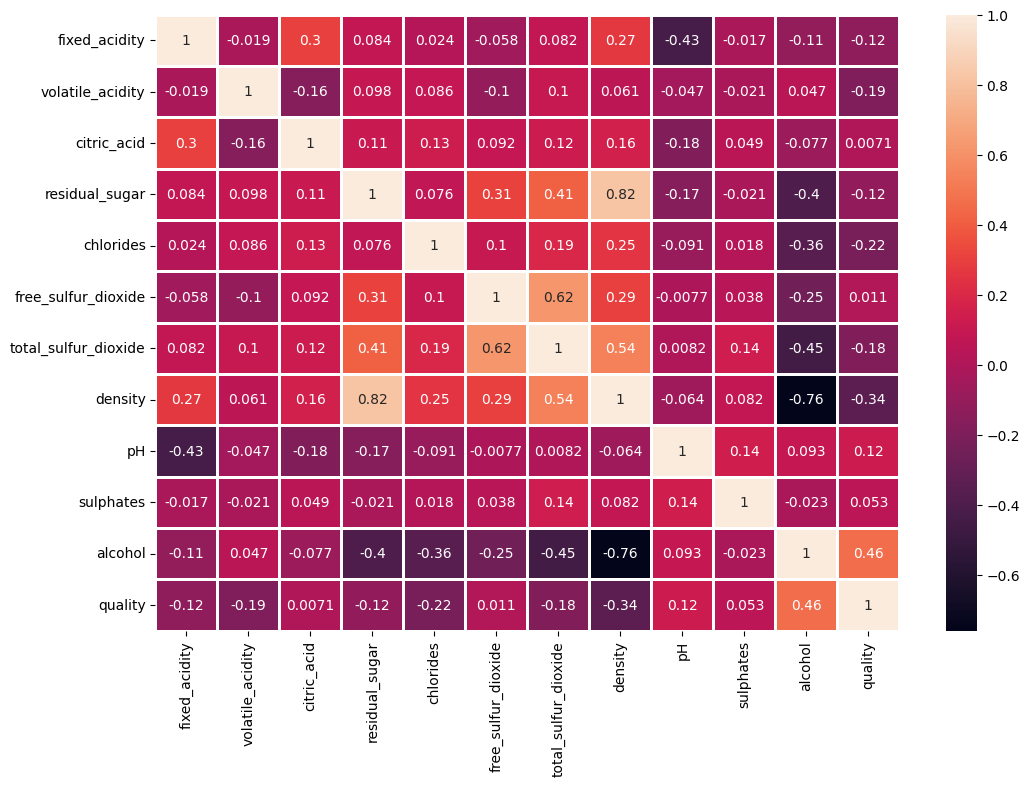

In [88]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.toPandas().corr(), annot=True, linewidths=1)

- Наблюдается существенная корреляция признака _alcohol_ c большей частью остальных признаков и главное - с целевым признаком _quality_ !!!
Считаю целесообразным удалить данный признак из набора данных
- Признак Общего диоксида серы (total sulfur dioxide) включает в себя свободную (free sulfur dioxide) и связанную форму, Но именно свободная форма оказывает влияние на вкус и запах вина !!!
Считаю целесообразным удалить признак Общего диоксида серы из-за его существенной корреляции с признаком свободной формы.

In [89]:
# Удалить признаки total_sulfur_dioxede и alcohol
cols_to_drop = ['total_sulfur_dioxide','alcohol']
df.drop(*cols_to_drop).show(5)

+-------------+----------------+-----------+--------------+---------+-------------------+-------+----+---------+-------+
|fixed_acidity|volatile_acidity|citric_acid|residual_sugar|chlorides|free_sulfur_dioxide|density|  pH|sulphates|quality|
+-------------+----------------+-----------+--------------+---------+-------------------+-------+----+---------+-------+
|          6.7|            0.23|       0.26|           1.4|     0.06|               33.0| 0.9934|3.24|     0.56|      6|
|          7.4|             0.2|       0.36|           1.2|    0.038|               44.0| 0.9926|3.36|     0.34|      6|
|          6.7|            0.17|        0.5|           2.1|    0.043|               27.0| 0.9923|3.15|     0.45|      6|
|          6.4|            0.24|       0.32|          14.9|    0.047|               54.0| 0.9968|3.28|      0.5|      6|
|          7.2|            0.55|       0.09|           1.5|    0.108|               16.0| 0.9938|3.07|     0.57|      4|
+-------------+----------------+

Визуализировать аномальные значения признаков

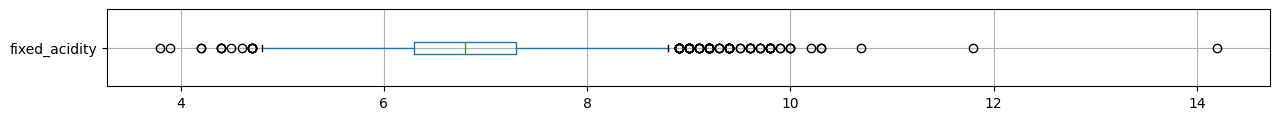

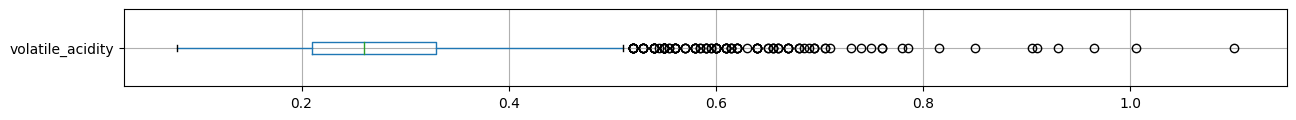

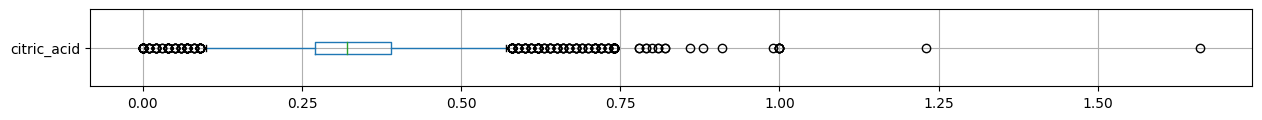

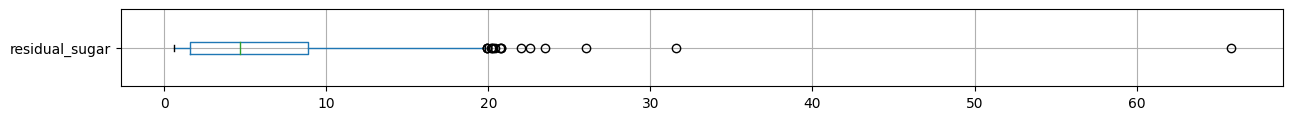

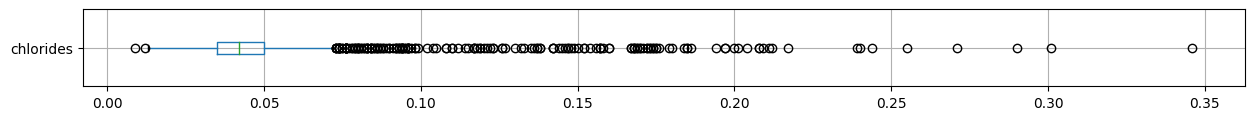

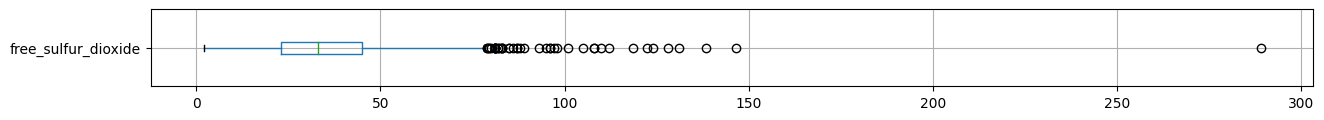

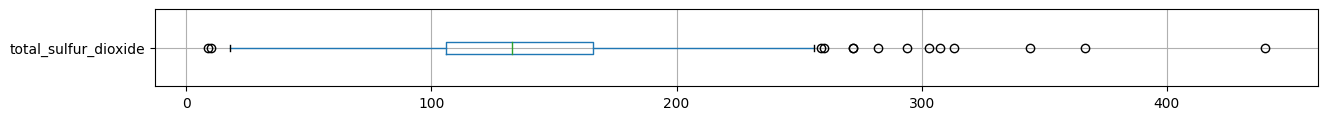

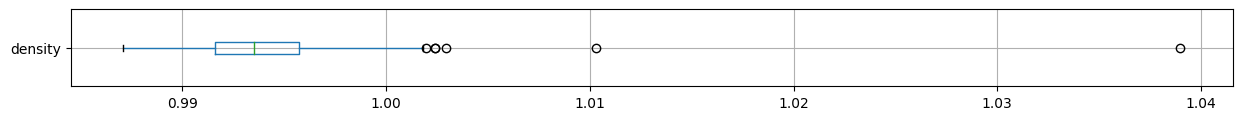

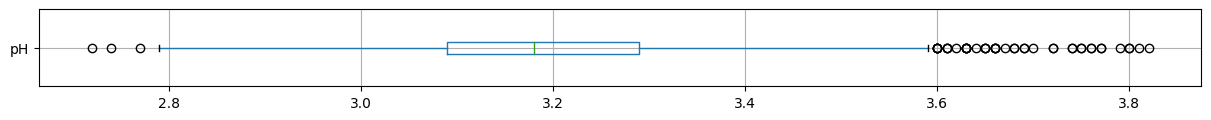

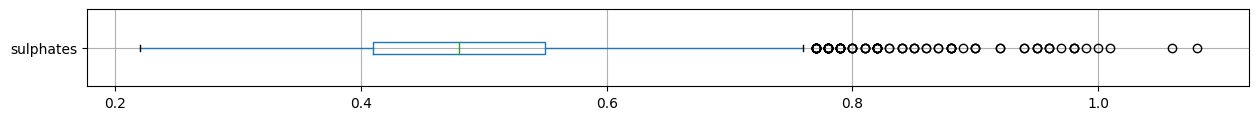

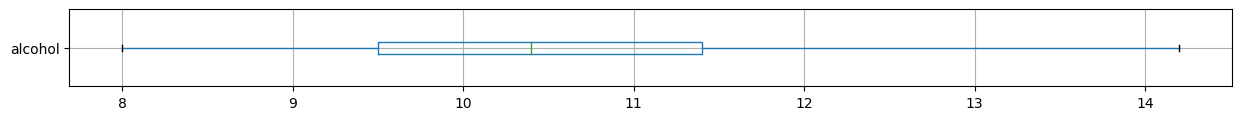

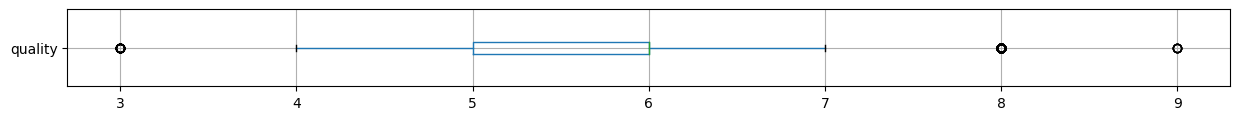

In [90]:
for col in df.columns:
    plt.figure(figsize=(15, 1))
    df.select(col).toPandas().boxplot(vert=0 )

In [91]:
# Визуализировать распределение значений признаков
df.toPandas().describe(include = "all").T

,count,mean,std,min,25%,50%,75%,max
fixed_acidity,3961.0,6.839346,0.866860,3.80000,6.30000,6.8000,7.30000,14.20000
volatile_acidity,3961.0,0.280538,0.103437,0.08000,0.21000,0.2600,0.33000,1.10000
citric_acid,3961.0,0.334332,0.122446,0.00000,0.27000,0.3200,0.39000,1.66000
residual_sugar,3961.0,5.914819,4.861646,0.60000,1.60000,4.7000,8.90000,65.80000
chlorides,3961.0,0.045905,0.023103,0.00900,0.03500,0.0420,0.05000,0.34600
free_sulfur_dioxide,3961.0,34.889169,17.210021,2.00000,23.00000,33.0000,45.00000,289.00000
total_sulfur_dioxide,3961.0,137.193512,43.129065,9.00000,106.00000,133.0000,166.00000,440.00000
density,3961.0,0.993790,0.002905,0.98711,0.99162,0.9935,0.99571,1.03898
pH,3961.0,3.195458,0.151546,2.72000,3.09000,3.1800,3.29000,3.82000
sulphates,3961.0,0.490351,0.113523,0.22000,0.41000,0.4800,0.55000,1.08000


In [92]:
# Удалить записи с максимальными значениями выбросов
df = df \
    .filter(df.fixed_acidity < 12)      \
    .filter(df.volatile_acidity < 1.1)  \
    .filter(df.citric_acid < 1.25)      \
    .filter(df.residual_sugar < 40)     \
    .filter(df.chlorides < 0.32)        \
    .filter(df.free_sulfur_dioxide < 150) \
    .filter(df.density < 1.02)

Оценить распределение значений классов целевой метрики "quality"

In [93]:
df.groupBy('quality').count().show()

+-------+-----+
|quality|count|
+-------+-----+
|      6| 1785|
|      3|   19|
|      5| 1174|
|      9|    5|
|      4|  152|
|      8|  131|
|      7|  689|
+-------+-----+



Набор целевых классов не сбалансированный.
- Выполним секвестр классов согласно бальной системы AIS (Итальянская ассоциация сомелье): 
    - ниже 6 балов - неудовлетворительно (0 балов)
    - 6 баллов - удовлетворительно (1 бал)
    - больше 6 балов - хорошо и отлично (2 бала)

Для оценки моделей будем применять метрики ROC_AUC, F-measure


In [94]:
df = df.withColumn('quality', F.when(df.quality < 6, 0).when(df.quality == 6, 1).when(df.quality > 6, 2))

df.groupBy('quality').count().show()

+-------+-----+
|quality|count|
+-------+-----+
|      1| 1785|
|      2|  825|
|      0| 1345|
+-------+-----+



Скалирование данных. Подготовка данных для обучения.

array([[<AxesSubplot: title={'center': 'fixed_acidity'}>,
        <AxesSubplot: title={'center': 'volatile_acidity'}>,
        <AxesSubplot: title={'center': 'citric_acid'}>],
       [<AxesSubplot: title={'center': 'residual_sugar'}>,
        <AxesSubplot: title={'center': 'chlorides'}>,
        <AxesSubplot: title={'center': 'free_sulfur_dioxide'}>],
       [<AxesSubplot: title={'center': 'total_sulfur_dioxide'}>,
        <AxesSubplot: title={'center': 'density'}>,
        <AxesSubplot: title={'center': 'pH'}>],
       [<AxesSubplot: title={'center': 'sulphates'}>,
        <AxesSubplot: title={'center': 'alcohol'}>,
        <AxesSubplot: title={'center': 'quality'}>]], dtype=object)

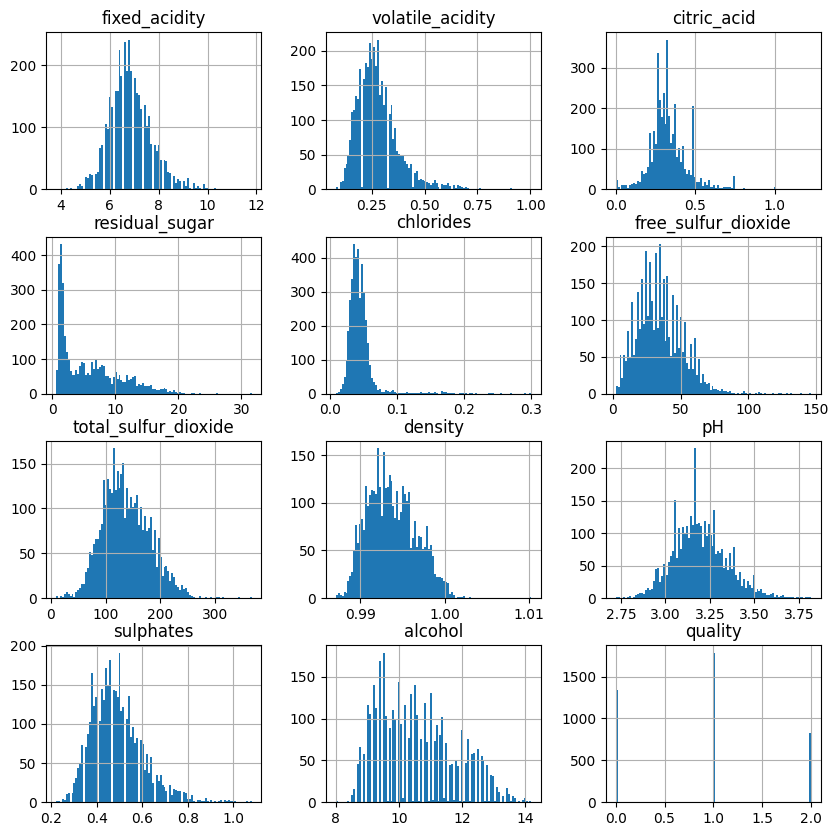

In [95]:
df.toPandas().hist(bins=100, figsize=(10,10))

Формирование вектора признаков для дальнейших преобразований

In [96]:
from pyspark.ml.feature import VectorAssembler

# Сформировать vector из заданных признаков
cols_to_vector = ['fixed_acidity','volatile_acidity','citric_acid','residual_sugar','chlorides','free_sulfur_dioxide','density','pH','sulphates']

vector_assembler = VectorAssembler(inputCols= cols_to_vector, outputCol='features')

data = vector_assembler.transform(df)
data.show(5)


+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+--------------------+
|fixed_acidity|volatile_acidity|citric_acid|residual_sugar|chlorides|free_sulfur_dioxide|total_sulfur_dioxide|density|  pH|sulphates|alcohol|quality|            features|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+--------------------+
|          6.7|            0.23|       0.26|           1.4|     0.06|               33.0|               154.0| 0.9934|3.24|     0.56|    9.5|      1|[6.7,0.23,0.26,1....|
|          7.4|             0.2|       0.36|           1.2|    0.038|               44.0|               111.0| 0.9926|3.36|     0.34|    9.9|      1|[7.4,0.2,0.36,1.2...|
|          6.7|            0.17|        0.5|           2.1|    0.043|               27.0|               122.0| 0.9923|3.15|     0.45|   10.3|    

Выполнить стандартное скалирование выделенных признаков

In [97]:
from pyspark.ml.feature import StandardScaler

feature_scaler = StandardScaler(inputCol='features', outputCol='scaled_features', withStd=True, withMean=True)

data_scaled = feature_scaler.fit(data).transform(data)

data_scaled.select(*['features','scaled_features']).show(5, truncate=False)

+-----------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|features                                       |scaled_features                                                                                                                                                                         |
+-----------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[6.7,0.23,0.26,1.4,0.06,33.0,0.9934,3.24,0.56] |[-0.16019473769663703,-0.491341564536597,-0.6134511231561024,-0.944012800094449,0.6264755227006099,-0.10935709576665635,-0.13484416803890187,0.2950951914599205,0.6146975827658636]     |
|[7.4,0.2,0.36,1.2,0.038,44.0,0.9926,3.36,0.34] |[0.65453683

Выполнить разбиение на обучающую и тестовую выборки

In [98]:
train, test = data_scaled.randomSplit([0.8, 0.2])

Обучение модели Логистической Регрессии

In [99]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol='scaled_features', labelCol='quality')

lr_model = lr.fit(train)

Оценка точности модели на тестовой выборке

In [100]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol='quality')

lr_preds = lr_model.transform(test)

print('Точность классификации:', evaluator.evaluate(lr_preds))

Точность классификации: 0.5647392039770108
